In [3]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [4]:
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D

import torch.nn.functional as F
import torch.optim as optim

from tqdm import tqdm
from sklearn import datasets

In [5]:
device = torch.device("cpu")

## 2D regression dataset

In [28]:
num_points = 100
# X1 = np.linspace(-2.5, 1.9, num_points)
X1 = np.linspace(-2.5, 2.5, num_points)
X2 = np.linspace(-2.5, 3, num_points)
# X2 = np.linspace(-2.2, 2.1, num_points)
X1, X2 = np.meshgrid(X1, X2)

Y = np.sin(np.sqrt(X1**2 + X2**2))*2-1. - 0.1*(X1)+0.02*(X2)
# Y = np.sqrt(X1**2 + X2**2)

####Scaling the data to range -1,1
X1 = 2*(X1 - X1.min())/(X1.max() - X1.min()) -1
X2 = 2*(X2 - X2.min())/(X2.max() - X2.min()) -1
Y = 2*(Y - Y.min())/(Y.max() - Y.min()) -1

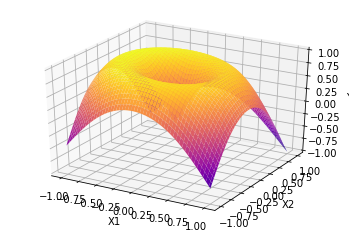

In [29]:
x1 = X1.reshape(-1)
x2 = X2.reshape(-1)
y = Y.reshape(-1)

xx = torch.Tensor(np.c_[x1, x2])
yy = torch.Tensor(Y.reshape(-1,1))

%matplotlib inline
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(X1, X2, Y, cmap='plasma')
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Y')
plt.show()

## Making of matrix factorized layer

In [46]:
class PairFactorizedWeight(nn.Module):
    
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
        self.num_factors = int(np.log2(dim))
        self.pair_indices = [self.get_pair_indices(dim, i+1) for i in range(self.num_factors)]
        self.pair_indices = [tuple(ind.t()) for ind in self.pair_indices]
        
        self.weights = []
        for _ in range(self.num_factors):
            w = nn.Parameter(torch.randn(dim*2))
            self.weights.append(w)
        self.weights = nn.ParameterList(self.weights)
#         self.zero_mat = torch.zeros(dim, dim)
        self.W = torch.eye(self.dim)
        
    def forward(self, x):
        W = self.W
        for pi, w in zip(self.pair_indices, self.weights):
            zero_mat = torch.zeros(self.dim, self.dim)
            zero_mat[pi] = w
            W = W@zero_mat
        return x@W

    def get_pair_indices(self, dim, step=1):
        assert 2**int(np.log2(dim)) == dim , "The dim must be power of 2"
        assert isinstance(step, int), "Step must be integer"

        blocks = (2**step)
        range_ = dim//blocks
        adder_ = torch.arange(0, range_)*blocks

        pairs_ = torch.Tensor([0, blocks//2])
        repeat_ = torch.arange(0, blocks//2).reshape(-1,1)

        block_map = (pairs_+repeat_).reshape(-1)
        reorder_for_pair = (block_map+adder_.reshape(-1,1)).reshape(-1)
        indx = reorder_for_pair.type(torch.long)
        indx = indx.reshape(-1, 2)

        map_idx = []
        for idx in indx:
            map_idx.append((idx[0], idx[0]))
            map_idx.append((idx[0], idx[1]))        
            map_idx.append((idx[1], idx[0]))        
            map_idx.append((idx[1], idx[1]))        
        map_idx = torch.LongTensor(map_idx)
        return map_idx

In [47]:
rfW = PairFactorizedWeight(8)

In [48]:
param_count = sum([torch.numel(p) for p in rfW.parameters()])
param_count

48

In [49]:
8*8/param_count

1.3333333333333333

In [54]:
class FactorNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.la1 = nn.Linear(2, 8)
        self.la2 = PairFactorizedWeight(8)
        self.bn2 = nn.BatchNorm1d(8)
        self.la3 = nn.Linear(8, 1)
        
    def forward(self, x):
        x = self.la1(x)
#         x = torch.relu(x)
        x = self.bn2(self.la2(x))
        x = torch.relu(x)
        x = self.la3(x)
        return x

In [55]:
model = FactorNet()

In [56]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

In [57]:
%matplotlib tk
fig = plt.figure(figsize=(9,8))
ax = fig.gca(projection='3d')

hardness = 0
for epoch in range(10000):

    yout = model(xx)
    loss = criterion(yout, yy)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch%200 == 0:
#         fig = plt.figure(figsize=(9,8))
#         ax = fig.gca(projection='3d')

        error = float(loss)
        print(f'Epoch:{epoch} | Error:{error}')
        ax.clear()
        
        ax.scatter(X1, X2, Y)
        yout_ = yout.data.reshape(Y.shape)
        ax.scatter(X1, X2, yout_, color='r', marker='.')
        ax.set_xlabel('X1')
        ax.set_ylabel('X2')
        ax.set_zlabel('Y')
        
        fig.canvas.draw()
        plt.pause(0.01)
#         plt.show()

Epoch:0 | Error:0.4399206042289734
Epoch:200 | Error:0.05012425407767296
Epoch:400 | Error:0.026056606322526932
Epoch:600 | Error:0.011449459940195084
Epoch:800 | Error:0.008678177371621132
Epoch:1000 | Error:0.008325809612870216
Epoch:1200 | Error:0.008110638707876205
Epoch:1400 | Error:0.007858993485569954
Epoch:1600 | Error:0.007597653195261955
Epoch:1800 | Error:0.007455172948539257
Epoch:2000 | Error:0.007419557310640812
Epoch:2200 | Error:0.007379992865025997
Epoch:2400 | Error:0.007056789938360453
Epoch:2600 | Error:0.006977641489356756
Epoch:2800 | Error:0.006976366974413395
Epoch:3000 | Error:0.006975054740905762
Epoch:3200 | Error:0.007002559024840593
Epoch:3400 | Error:0.0069725061766803265
Epoch:3600 | Error:0.006990399211645126
Epoch:3800 | Error:0.006994505878537893
Epoch:4000 | Error:0.006994650233536959
Epoch:4200 | Error:0.006997496820986271
Epoch:4400 | Error:0.00703143747523427
Epoch:4600 | Error:0.00702471612021327
Epoch:4800 | Error:0.007005433086305857
Epoch:5000 

TclError: invalid command name "."

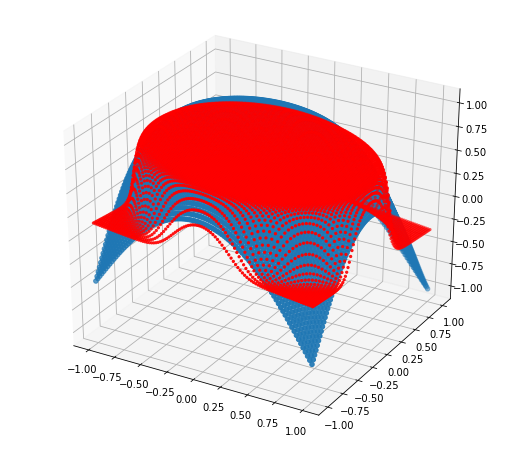

In [199]:
%matplotlib inline
fig = plt.figure(figsize=(9,8))
ax = fig.gca(projection='3d')
ax.scatter(X1, X2, Y)
ax.scatter(X1, X2, yout.data.reshape(Y.shape), color='r', marker='.')
plt.show()